In [458]:
import numpy as np
import random
import pandas as pd
from itertools import product

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import auc, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [436]:
data = pd.read_csv('real_train.csv')

In [437]:
data.columns

Index(['Peptide', 'MHC', 'Immunogenicity'], dtype='object')

In [462]:
X[:5]

,Peptide,MHC
0,DSMQYTYKIV,H2-Db
1,SLLKYFFVL,H2-Kb
2,ILYVPMSLSM,H2-Kb
3,NQLLARPFL,H2-Db
4,AEMEKEGKI,H2-Kk


In [438]:
X = data[['Peptide', 'MHC']]
y = data['Immunogenicity']

In [203]:
#y = y.values.reshape(-1)

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [352]:
# # amino-acids from http://athina.biol.uoa.gr/FT/AA_codes.html
# # fake mhc_types

# amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
# mhc_types = ['H2-1', 'H2-2', 'H2-3', 'H2-4', 'H2-5', 'H2-6']
# letter_tuples = product(amino_acids, repeat=k)
# words = (["".join(letter_tuple) for letter_tuple in letter_tuples])
# word2token = {word: index for index, word in enumerate(words)}

In [446]:
preprocessors = [
('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (2,2)), 'Peptide'),
('ohe_mhc', OneHotEncoder(), ['MHC'])
]

preprocessing_pipe = ColumnTransformer(preprocessors)

clf = Pipeline([('prepoc', preprocessing_pipe),
                ('forest', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
                ])

param_dist = {"forest__n_estimators": sp_randint(30, 200),
              "forest__max_depth": sp_randint(3, 10),
              "forest__max_features": sp_randint(2, 30),
              "forest__min_samples_split": sp_randint(2, 11),
              "forest__bootstrap": [True, False],
              "forest__criterion": ["gini", "entropy"]}

n_iter_search = 2
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)
y_pred_test = forest_search.predict_proba(X_test)
roc_auc_score(y_test, y_pred_test[:, 1])

0.6522635386743272

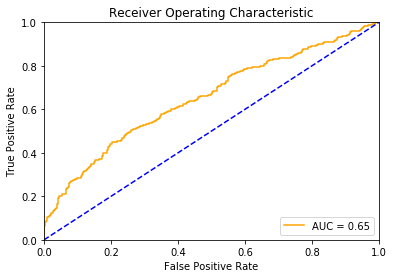

In [459]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_test[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='#0000FF')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [445]:
preprocessors = [
('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (2,2)), 'Peptide'),
('ohe_mhc', OneHotEncoder(), ['MHC'])
]

preprocessing_pipe = ColumnTransformer(preprocessors)

clf_forest = Pipeline([('prepoc', preprocessing_pipe),
                       ('forest', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
                      ])

param_dist_forest = {"forest__n_estimators": sp_randint(30, 200),
              "forest__max_depth": sp_randint(3, 10),
              "forest__max_features": sp_randint(2, 30),
              "forest__min_samples_split": sp_randint(2, 11),
              "forest__bootstrap": [True, False],
              "forest__criterion": ["gini", "entropy"]}

clf_extra = Pipeline([('prepoc', preprocessing_pipe),
                       ('extra', ExtraTreesClassifier(class_weight='balanced', n_jobs=-1))
                      ])

param_dist_extra = {"extra__n_estimators": sp_randint(30, 200),
              "extra__max_depth": sp_randint(3, 10),
              "extra__max_features": sp_randint(2, 30),
              "extra__min_samples_split": sp_randint(2, 11),
              "extra__bootstrap": [True, False],
              "extra__criterion": ["gini", "entropy"]}

In [442]:
n_iter_search = 2
forest_search = RandomizedSearchCV(clf_forest, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)
extra_search = RandomizedSearchCV(clf_extra, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)


In [443]:
forest_search.fit(X_train, y_train)
y_pred_test = forest_search.predict_proba(X_test)
roc_auc_score(y_test, y_pred_test[:, 1])

0.6522635386743272

In [444]:
extra_search.fit(X_train, y_train)
y_pred_test = forest_search.predict_proba(X_test)
roc_auc_score(y_test, y_pred_test[:, 1])

0.6522635386743272

In [434]:
roc_auc_score(y_test, y_pred_test[:, 1])

0.6651815796006668

In [355]:
X_train_prepoc = preprocessing_pipe.fit_transform(X_train)

In [359]:
X_train_prepoc[:,:10].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [143]:
X[:5]

,Peptide,MHC
0,DSMQYTYKIV,H2-Db
1,SLLKYFFVL,H2-Kb
2,ILYVPMSLSM,H2-Kb
3,NQLLARPFL,H2-Db
4,AEMEKEGKI,H2-Kk


In [64]:
list(product(amino_acids, repeat=k))

[('A', 'A', 'A'),
 ('A', 'A', 'R'),
 ('A', 'A', 'N'),
 ('A', 'A', 'D'),
 ('A', 'A', 'C'),
 ('A', 'A', 'Q'),
 ('A', 'A', 'E'),
 ('A', 'A', 'G'),
 ('A', 'A', 'H'),
 ('A', 'A', 'I'),
 ('A', 'A', 'L'),
 ('A', 'A', 'K'),
 ('A', 'A', 'M'),
 ('A', 'A', 'F'),
 ('A', 'A', 'P'),
 ('A', 'A', 'S'),
 ('A', 'A', 'T'),
 ('A', 'A', 'W'),
 ('A', 'A', 'Y'),
 ('A', 'A', 'V'),
 ('A', 'R', 'A'),
 ('A', 'R', 'R'),
 ('A', 'R', 'N'),
 ('A', 'R', 'D'),
 ('A', 'R', 'C'),
 ('A', 'R', 'Q'),
 ('A', 'R', 'E'),
 ('A', 'R', 'G'),
 ('A', 'R', 'H'),
 ('A', 'R', 'I'),
 ('A', 'R', 'L'),
 ('A', 'R', 'K'),
 ('A', 'R', 'M'),
 ('A', 'R', 'F'),
 ('A', 'R', 'P'),
 ('A', 'R', 'S'),
 ('A', 'R', 'T'),
 ('A', 'R', 'W'),
 ('A', 'R', 'Y'),
 ('A', 'R', 'V'),
 ('A', 'N', 'A'),
 ('A', 'N', 'R'),
 ('A', 'N', 'N'),
 ('A', 'N', 'D'),
 ('A', 'N', 'C'),
 ('A', 'N', 'Q'),
 ('A', 'N', 'E'),
 ('A', 'N', 'G'),
 ('A', 'N', 'H'),
 ('A', 'N', 'I'),
 ('A', 'N', 'L'),
 ('A', 'N', 'K'),
 ('A', 'N', 'M'),
 ('A', 'N', 'F'),
 ('A', 'N', 'P'),
 ('A', 'N'

In [86]:
data.amino_acids[:10]

0       ESERECSG
1    HANNFYERDNN
2     KYMKITGGVS
3      FVLGQAETG
4    LFQRWYYIYTH
5    YPPEFYNTLCV
6    WNGFQAKTQQG
7      VHMSMTHIY
8     KYSFDNKEFK
9       RFPGQDVR
Name: amino_acids, dtype: object

In [87]:
[[word2token[sentence[index : index + k]] for index in range(len(sentence) - k + 1)] for sentence in data.amino_acids]

[[2706, 6121, 2426, 524, 2495, 1907],
 [3202, 42, 853, 1078, 5566, 7321, 2423, 462, 1242],
 [4772, 7451, 5029, 4596, 3927, 6547, 2959, 3195],
 [5590, 7807, 4145, 2900, 2006, 136, 2727],
 [4265, 5301, 2037, 758, 7178, 7569, 7398, 3976, 7528],
 [7494, 5886, 5733, 2678, 5562, 7256, 1130, 6604, 4099],
 [6847, 953, 3065, 5300, 2011, 236, 4725, 6505, 2107],
 [7772, 3455, 5112, 6256, 5128, 6569, 3398],
 [4775, 7513, 6263, 5262, 1251, 1026, 4533, 2671],
 [674, 5487, 5745, 2903, 2079, 1581],
 [182, 3640, 804, 92, 1850, 5008],
 [47, 958, 3162, 7247, 946, 2927, 2543, 2867, 1352],
 [4831, 635, 4700, 6002, 46, 925, 2510, 2208, 4168],
 [282, 5641, 828, 564, 3282, 1653, 1063, 5262, 1255],
 [6702, 6044, 882, 1650, 1016, 4334, 6685],
 [4374, 7489, 5787, 3755, 3116, 6338, 6760],
 [6556, 3132, 6640, 4807, 156, 3133, 6676, 5520],
 [7826, 4535, 2718, 6362, 7251, 1032, 4641, 4831],
 [3268, 1364, 3290, 1813, 4275, 5502, 6056],
 [5265, 1309, 2191, 3827, 4542, 2857, 1146],
 [297, 5957, 7151, 7028, 4572, 3444, 

In [111]:
class Kmer_Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
        self.amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        letter_tuples = product(amino_acids, repeat=k)
        words = (["".join(letter_tuple) for letter_tuple in letter_tuples])
        self.word2token = {word: index for index, word in enumerate(words)}
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return [[self.word2token[sentence[index : index + self.k]]\
          for index in range(len(sentence) - self.k + 1)]\
          for sentence in X.values]

In [112]:
kmerizer = Kmer_Tokenizer(3)

In [113]:
kmerizer.fit_transform(data['amino_acids'])

[[2706, 6121, 2426, 524, 2495, 1907],
 [3202, 42, 853, 1078, 5566, 7321, 2423, 462, 1242],
 [4772, 7451, 5029, 4596, 3927, 6547, 2959, 3195],
 [5590, 7807, 4145, 2900, 2006, 136, 2727],
 [4265, 5301, 2037, 758, 7178, 7569, 7398, 3976, 7528],
 [7494, 5886, 5733, 2678, 5562, 7256, 1130, 6604, 4099],
 [6847, 953, 3065, 5300, 2011, 236, 4725, 6505, 2107],
 [7772, 3455, 5112, 6256, 5128, 6569, 3398],
 [4775, 7513, 6263, 5262, 1251, 1026, 4533, 2671],
 [674, 5487, 5745, 2903, 2079, 1581],
 [182, 3640, 804, 92, 1850, 5008],
 [47, 958, 3162, 7247, 946, 2927, 2543, 2867, 1352],
 [4831, 635, 4700, 6002, 46, 925, 2510, 2208, 4168],
 [282, 5641, 828, 564, 3282, 1653, 1063, 5262, 1255],
 [6702, 6044, 882, 1650, 1016, 4334, 6685],
 [4374, 7489, 5787, 3755, 3116, 6338, 6760],
 [6556, 3132, 6640, 4807, 156, 3133, 6676, 5520],
 [7826, 4535, 2718, 6362, 7251, 1032, 4641, 4831],
 [3268, 1364, 3290, 1813, 4275, 5502, 6056],
 [5265, 1309, 2191, 3827, 4542, 2857, 1146],
 [297, 5957, 7151, 7028, 4572, 3444, 

In [101]:
k

3

In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data.amino_acids
vectorizer = TfidfVectorizer(analyzer = 'char', ngram_range = (1,1))
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

AttributeError: 'DataFrame' object has no attribute 'amino_acids'

In [ ]:
skf = StratifiedKFold(n_splits=1)

In [ ]:
TfidfVectorizer(analyzer = 'char', ngram_range = (2,2))

In [328]:
clf_logreg = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (2,2))),\
                       ('logreg', LogisticRegression(class_weight='balanced', solver='lbfgs'))
                      ])

In [329]:
clf_forest = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (3,3))),\
                       ('forest', RandomForestClassifier(n_estimators = 100, class_weight='balanced'))])

In [330]:
clf_bayes = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (3,3))),\
                       ('bayes', ComplementNB())])

In [331]:
clf_boost = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (3,3))),\
                      ('boost', GradientBoostingClassifier(learning_rate=0.06, n_estimators=200))])

In [332]:
clf_extra = Pipeline([('tfidf', TfidfVectorizer(analyzer = 'char', ngram_range = (3,3))),\
                      ('extra', ExtraTreesClassifier(n_estimators=200))])

In [333]:
clf_logreg.fit(X_train.values.reshape(-1), y_train)
y_pred_test = clf_logreg.predict_proba(X_test.values.reshape(-1))
roc_auc_score(y_test, y_pred_test[:, 1])

0.6634792708444159

In [334]:
clf_forest.fit(X_train.values.reshape(-1), y_train)
y_pred_test = clf_forest.predict_proba(X_test.values.reshape(-1))
roc_auc_score(y_test, y_pred_test[:, 1])

0.6655340107103593

In [335]:
clf_bayes.fit(X_train.values.reshape(-1), y_train)
y_pred_test = clf_bayes.predict_proba(X_test.values.reshape(-1))
roc_auc_score(y_test, y_pred_test[:, 1])

0.6460527715714439

In [336]:
clf_boost.fit(X_train.values.reshape(-1), y_train)
y_pred_test = clf_boost.predict_proba(X_test.values.reshape(-1))
roc_auc_score(y_test, y_pred_test[:, 1])

0.59018689931553

In [337]:
clf_extra.fit(X_train.values.reshape(-1), y_train)
y_pred_test = clf_extra.predict_proba(X_test.values.reshape(-1))
roc_auc_score(y_test, y_pred_test[:, 1])

0.6776053303542932

In [285]:
y_pred_test = clf_boost.predict_proba(X_test.values.reshape(-1))
roc_auc_score(y_test, y_pred_test[:, 1])

In [286]:
roc_auc_score(y_test, y_pred_test[:, 1])

0.5839783487605064

In [266]:
y_pred_test = clf_forest.predict_proba(X_test.values.reshape(-1))

In [267]:
roc_auc_score(y_test, y_pred_test[:, 1])

0.672097208922935

In [188]:
y_test.values.reshape(-1).shape, y_pred_test.shape

((1177,), (1177,))